# Multimodal Models Toolkit
multimodal-model-toolkit (MMMT, pronounced *mammut*) is a platform for accelerating research and development with data in multiple modalities, from data pre-processing, to model evaluation.

## What does this notebook do?
This notebook demonstrates an end to end use case for the multimodal toolkit:

- Loading a multimodal dataset: using a *Sample ID decoder* to convert a series of unique ids
 to a [Fuse](https://github.com/IBM/fuse-med-ml/blob/master/fuse/data/datasets/dataset_default.py) 
 Dataset.
- Obtaining a Graph-Based Multimodal Representation (GBMR) of a dataset
    - using modality specific feature extraction through either user-provided models, or unsupervised 
    autoencoder representations, or just as they are (raw representation from the dataset)
    - training an autoencoder on the concatenated features from the individual modalities
    to identify common *concepts* across modality features
    - building a graph that links modality features according to those concepts
- Visualizing the graph representation of the dataset
- Using the GBMR to train a variety of graph neural networks to solve a specific task

## What does the user need to provide?
![](user_input.png)

We have tried to keep the interaction of the user to a minimum:
- provide a `data_loading_pipeline` for the dataset of choice
- provide the `encoding_strategy` for each modality (user model and/or autoencoder, none), see schema above
- provide a `graph_module_configuration` with one of the supported GNNs and define the model head, see schema above


## Before starting

1. Download the KNIGHT dataset with the following commands
```
git clone https://github.com/neheller/KNIGHT.git
python KNIGHT/knight/scripts/get_imaging.py
mv KNIGHT/knight/data [..]/knight_data
```

2. Specify the location of the data in the configuration yaml (`data_path` of object `KNIGHT.static_pipeline`).

3. Install MMMT in your environment with the following cell (see also [readme](../../README.md)).

In [ ]:
%pip install git+ssh://git@github.ibm.com/HCLS-innersource/multimodal-model-toolkit

In [ ]:
import logging
import os
from mmmt.pipeline.pipeline import MMMTPipeline

from mmmt.data.graph.visualization import GraphVisualization

import fuseimg.datasets.knight
from fuse.utils import NDict
import knight_eval
import get_splits

logging.basicConfig(level=logging.ERROR)

### User input required:
User input is contained in a yaml. One general setting and 4 main phases can be distinguished in the yaml:
- `cache`: a general setting defining the cache for the fuse data pipeline
- `data`: a list of steps to apply to each sample_id to obtain the desired data in the
appropriate dictionary keys 
- `modality_encoding_strategy`: how should the unimodal representations be encoded
- `fusion_strategy`: how should the encoded unimodal representations be fused and represented
- `task_strategy`: how should the prediction task be solved


The yaml file is read from `mmmt_examples/knight/mmmt_pipeline_config_demonstration.yaml`.

Below the main arguments are also reported and documented.

```yaml

cache:  # configurations needed for the caching
  num_workers: 1  # number of workers
  restart_cache: True  # whether to delete the cache before staring
  root_dir: "_examples/knight"  # directory used for caching and storage of the models checkpoints

data:  # list of object to pre-process the data
  - fuse_object: "KNIGHT.static_pipeline"  # first step in data processing, in this case we use a fuse object to import the KNIGHT data
    args:  # arguments needed for the first step in the data processing
      data_path: "KNIGHT/knight/data"

  - object: "get_splits_str_ids"  # second step in data processing, in this case to split the dataset in a consistent way accross runs
    args:  # arguments needed for the second step in the data processing
      pickle_path: "multimodal-model-toolkit/mmmt_examples/knight/splits_final.pkl"


modality_encoding_strategy:  # list of objects to encode the modalities
  - object: "ModalityEncoding"  # encode independently each modality
    args:  # arguments needed for ModalityEncoding
      data.input.img:
        model: "backbone_resnet"
        model_path: "data/trained_models/mmmt_backbone3d/backbone3d.pth"
        encoding_layers:
          - 64
          - 32
        batch_size: 3
        training:
          pl_trainer_num_epochs: 1
          pl_trainer_accelerator: "cpu"


fusion_strategy:  # list of objects to fuse the modalities
  - object: "EncodedUnimodalToConcept"  # get single modalities to a common encoding
    args:  # arguments needed for EncodedUnimodalToConcept
      encoding_layers:
        - 32
        - &n_layers 16
      batch_size: 3
      training:
        pl_trainer_num_epochs: 1
        pl_trainer_accelerator: "cpu"

  - object: "ConceptToGraph"  # build graphs
    args:  # arguments needed for ConceptToGraph
      module_identifier: &graph_module "mplex"
      thresh_q: 0.95


task_strategy:  # list of objects to solve the ML task
  - object: "MultimodalGraphModel"  # build and train the graph model
    args:  # arguments needed for MultimodalGraphModel
      model_config:
        graph_model:
          module_identifier: *graph_module
          n_layers: *n_layers
          node_emb_dim: 1
        head_model:
          head_hidden_size:
            - 50
            - 20
          dropout: 0.5
        num_classes: 2

      training:
        batch_size: 3
        pl_trainer_num_epochs: 1
        pl_trainer_accelerator: "cpu"
        pl_trainer_devices: 1
```

## Running the pipeline

In [2]:
os.chdir("../../")
mmmt_pipeline_config_path = 'mmmt_examples/knight/mmmt_pipeline_config_demonstration.yaml'

# Specify specific objects needed for this particular example
specific_objects = {
    "KNIGHT.static_pipeline": {
        "object": fuseimg.datasets.knight.KNIGHT.static_pipeline,
    },
    "Eval": {
        "object": knight_eval.knight_eval,
        "need_cache": True,
    },
    "get_splits_str_ids": {
        "object": get_splits.get_splits_str_ids,
    },
}

In [ ]:
# Initialize the pipeline
MMMTP = MMMTPipeline(mmmt_pipeline_config_path, specific_objects)

# Run the pipeline - option debugging=True will only use the first 3 samples for each dataset
MMMTP.run_pipeline(debugging=True)

logging.info("MMMT pipeline completed")

## Insights

In [ ]:
# Visualize the pipeline just executed
data_pipeline = MMMTP.pipeline["fuse_pipeline"]

gvgraph = GraphVisualization.visualize_fuse_pipeline(data_pipeline, name="Graph Based Multimodal Representation", source_keys=['data.input.image_path', 'data.input.clinical_features'])

gvgraph.save('_examples/pipeline.gv')
# for visualising, the line below needs graphviz executable installed, e.g. for mac run `brew install graphviz`
# gvgraph.view()

#### Pipeline visualisation results

![Data Transformation Pipeline](./pipeline.gv.png)

### Visualize the pipeline results
Each sample has been transformed in a graph.
Intuitively, an edge displays the combination of 2 features (which can be from the same modality or from different ones) that is important to reconstruct the signal.

The cells below visualize the graph for one sample and the aggregation of all samples (sum of the adjacency matrices).

In [6]:
# node categories structure for the encoding strategy above. 
# It is only used for visualization: assigns a category to the nodes, so that all nodes of the same category receive the same color and label.
node_categories = [
        "nephrectomy",
        "body_mass_index",
        "smoking",
        "pack_years",
        "radiographic_size",
        "nephrectomy",
        "nephrectomy",
        "voxel_spacing",
        "voxel_spacing",
        "voxel_spacing",
        "gender",
        "gender",
        "gender",
        "smoking",
        "smoking",
        "smoking",
        "chewing_tobacco",
        "chewing_tobacco",
        "alcohol_use",
        "alcohol_use",
        "alcohol_use",
        "alcohol_use",
        "alcohol_use"
    ] + ["comorbidities"]*37 + ["image"]*64

graph_train_dataset = MMMTP.pipeline['fused_dataset']['graph_train_dataset']


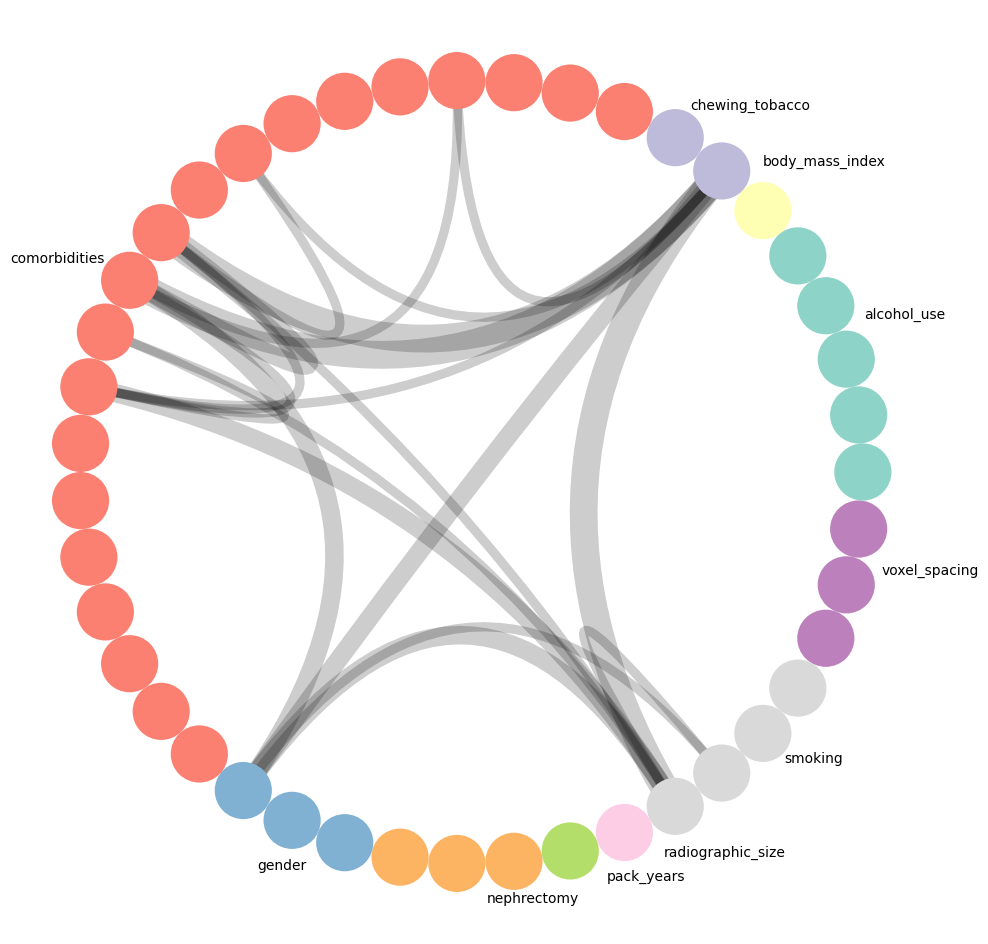

In [14]:
# Visualize one sample
G = GraphVisualization.visualize_dataset(graph_train_dataset, graph_key= "data.base_graph.graph", node_categories=node_categories, samples=['case_00000'])

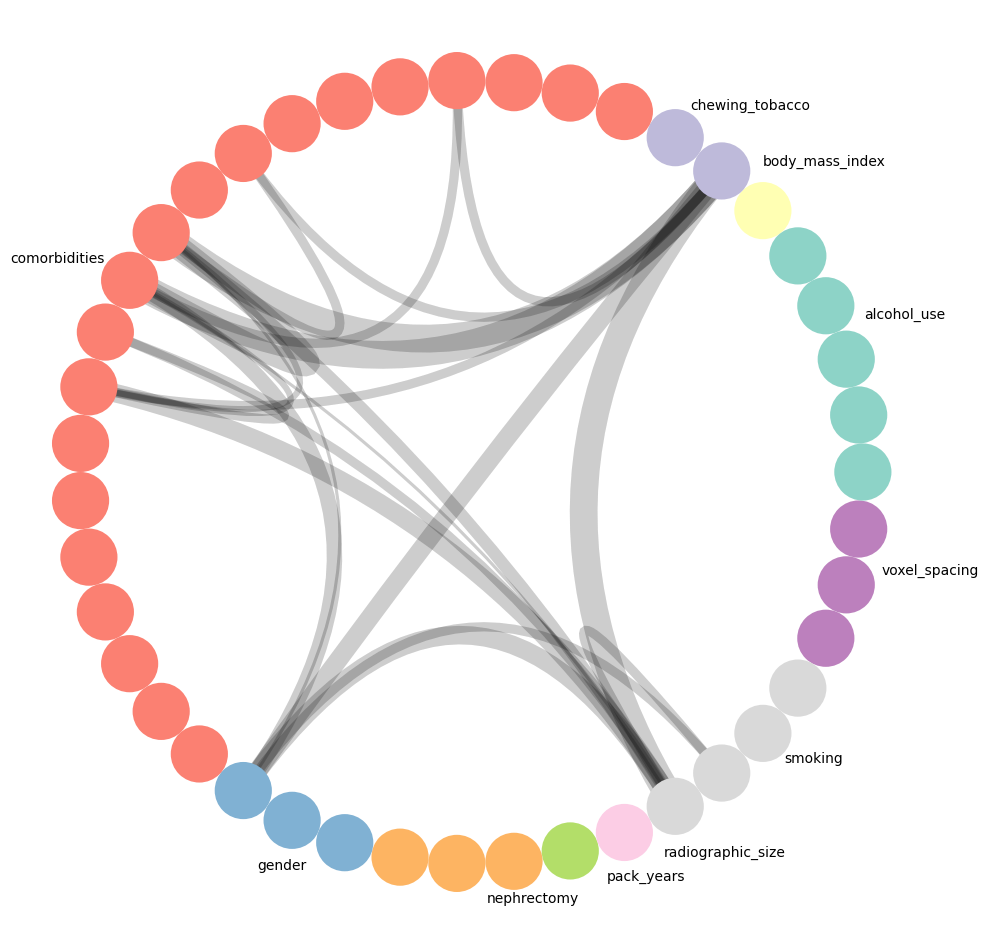

In [8]:
# Visualize all samples
G = GraphVisualization.visualize_dataset(graph_train_dataset, graph_key= "data.base_graph.graph", node_categories=node_categories, samples=None)

### Finally, inspect the computed metrics on the test set

In [10]:
# Metrics are stored under the Eval key (operator specified in the defaults.yaml) 
# and are stored in evaluation directory (also specified in defaults.yaml)

for metric_name in MMMTP.pipeline['Eval']['metrics']:
    metric_result = MMMTP.pipeline['Eval']['metrics'][metric_name]
    print(f"Metric {metric_name}:")
    print("------------------------------------------------")

    if isinstance(metric_result, dict):
        metric_result = NDict(metric_result)
        keys = metric_result.keypaths()
        for key in keys:
            print(f"{key}:\n{metric_result[key]}\n")
    else:
        print(f"{metric_result}\n")

Metric roc_curve:
------------------------------------------------
Positive.fpr:
[0.         0.33333333 1.        ]

Positive.tpr:
[nan nan nan]

Positive.auc:
nan

